# Challenge: Factors that affect life expectancy

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)
engine.dispose()

life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [53]:
pd.set_option('display.max_columns', None)
life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [54]:
life_df.isnull().sum()/life_df.isnull().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.003404
Adult Mortality                    0.003404
infant deaths                      0.000000
Alcohol                            0.066031
percentage expenditure             0.000000
Hepatitis B                        0.188223
Measles                            0.000000
 BMI                               0.011572
under-five deaths                  0.000000
Polio                              0.006467
Total expenditure                  0.076923
Diphtheria                         0.006467
 HIV/AIDS                          0.000000
GDP                                0.152485
Population                         0.221920
 thinness  1-19 years              0.011572
 thinness 5-9 years                0.011572
Income composition of resources    0.056841
Schooling                          0.055480
dtype: float64

There are some missing values. Beacause the data is classified for each specific country, it is better that we fill missing fields based on each country's other values.

In [55]:
life_df1 = life_df.copy()

countries = life_df1['Country'].unique()

fill_list = life_df1.select_dtypes(include=['int64', 'float64'])

# Filling missing values with mean of other values of each country
for country in countries:
    life_df1.fillna({x: life_df1.loc[life_df1['Country'] == country][x].mean() for x in fill_list}, inplace = True)
    
life_df1.isnull().sum()/life_df1.isnull().count()    

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
 BMI                               0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
 HIV/AIDS                          0.0
GDP                                0.0
Population                         0.0
 thinness  1-19 years              0.0
 thinness 5-9 years                0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

In [72]:
for col in life_df1.columns: 
    print(col) 

Country
Year
Status
Life expectancy 
Adult Mortality
infant deaths
Alcohol
percentage expenditure
Hepatitis B
Measles 
 BMI 
under-five deaths 
Polio
Total expenditure
Diphtheria 
 HIV/AIDS
GDP
Population
 thinness  1-19 years
 thinness 5-9 years
Income composition of resources
Schooling


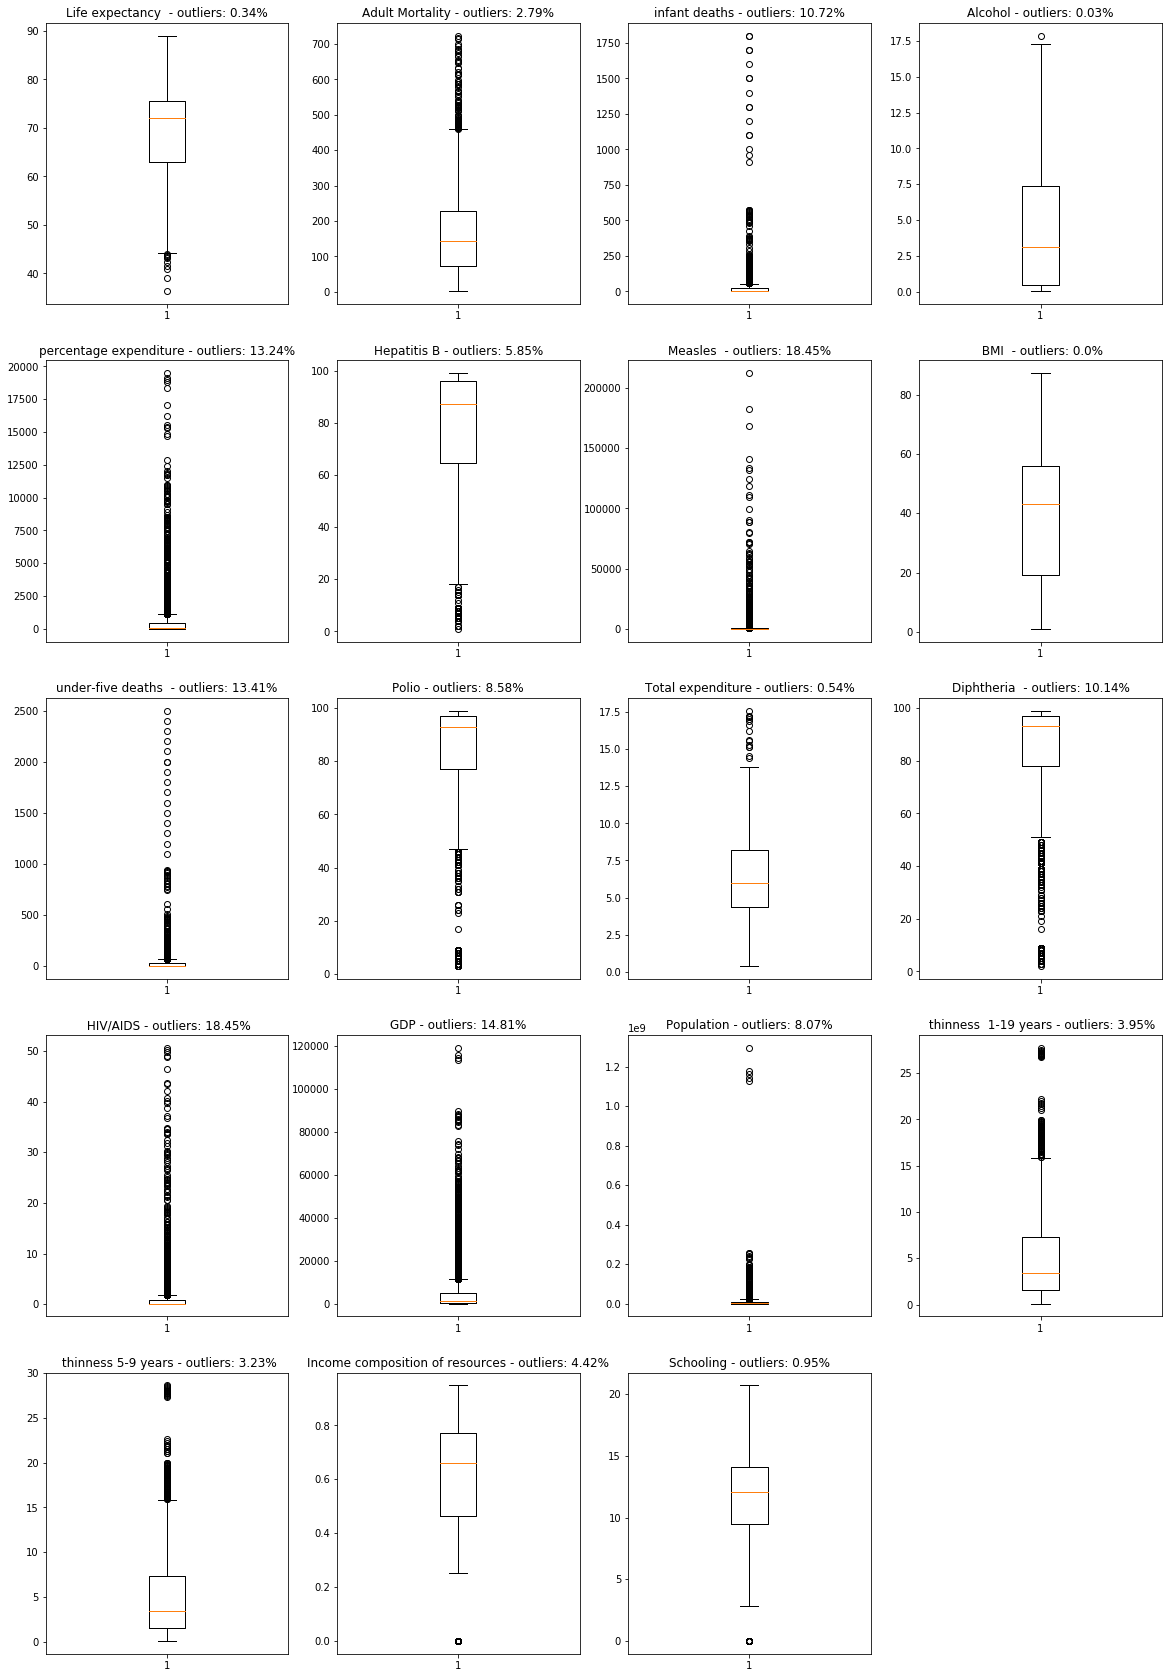

In [56]:
def outliers(x):
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    num = len((np.where((x > max_val) 
                      | (x < min_val))[0]))
    return round((num * 100)/len(x), 2)


columns = {'Life expectancy ':1,'Adult Mortality':2,'infant deaths':3,'Alcohol':4,'percentage expenditure':5,'Hepatitis B':6,
           'Measles ':7, ' BMI ':8,'under-five deaths ':9,'Polio':10,'Total expenditure':11,'Diphtheria ':12,' HIV/AIDS':13,'GDP':14,
           'Population':15, ' thinness  1-19 years':16,' thinness 5-9 years':17,'Income composition of resources':18,'Schooling':19}

# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,30))

for variable,i in columns.items():
                     plt.subplot(5,4,i)
                     plt.boxplot(life_df1[variable],whis=1.5)
                     plt.title('{} - outliers: {}%'.format(variable, outliers(life_df1[variable])))

plt.show()

Some variables contain a high percentage of outliers, and we have to pay attention for winsorizing them because some changes may impact significantly the results.

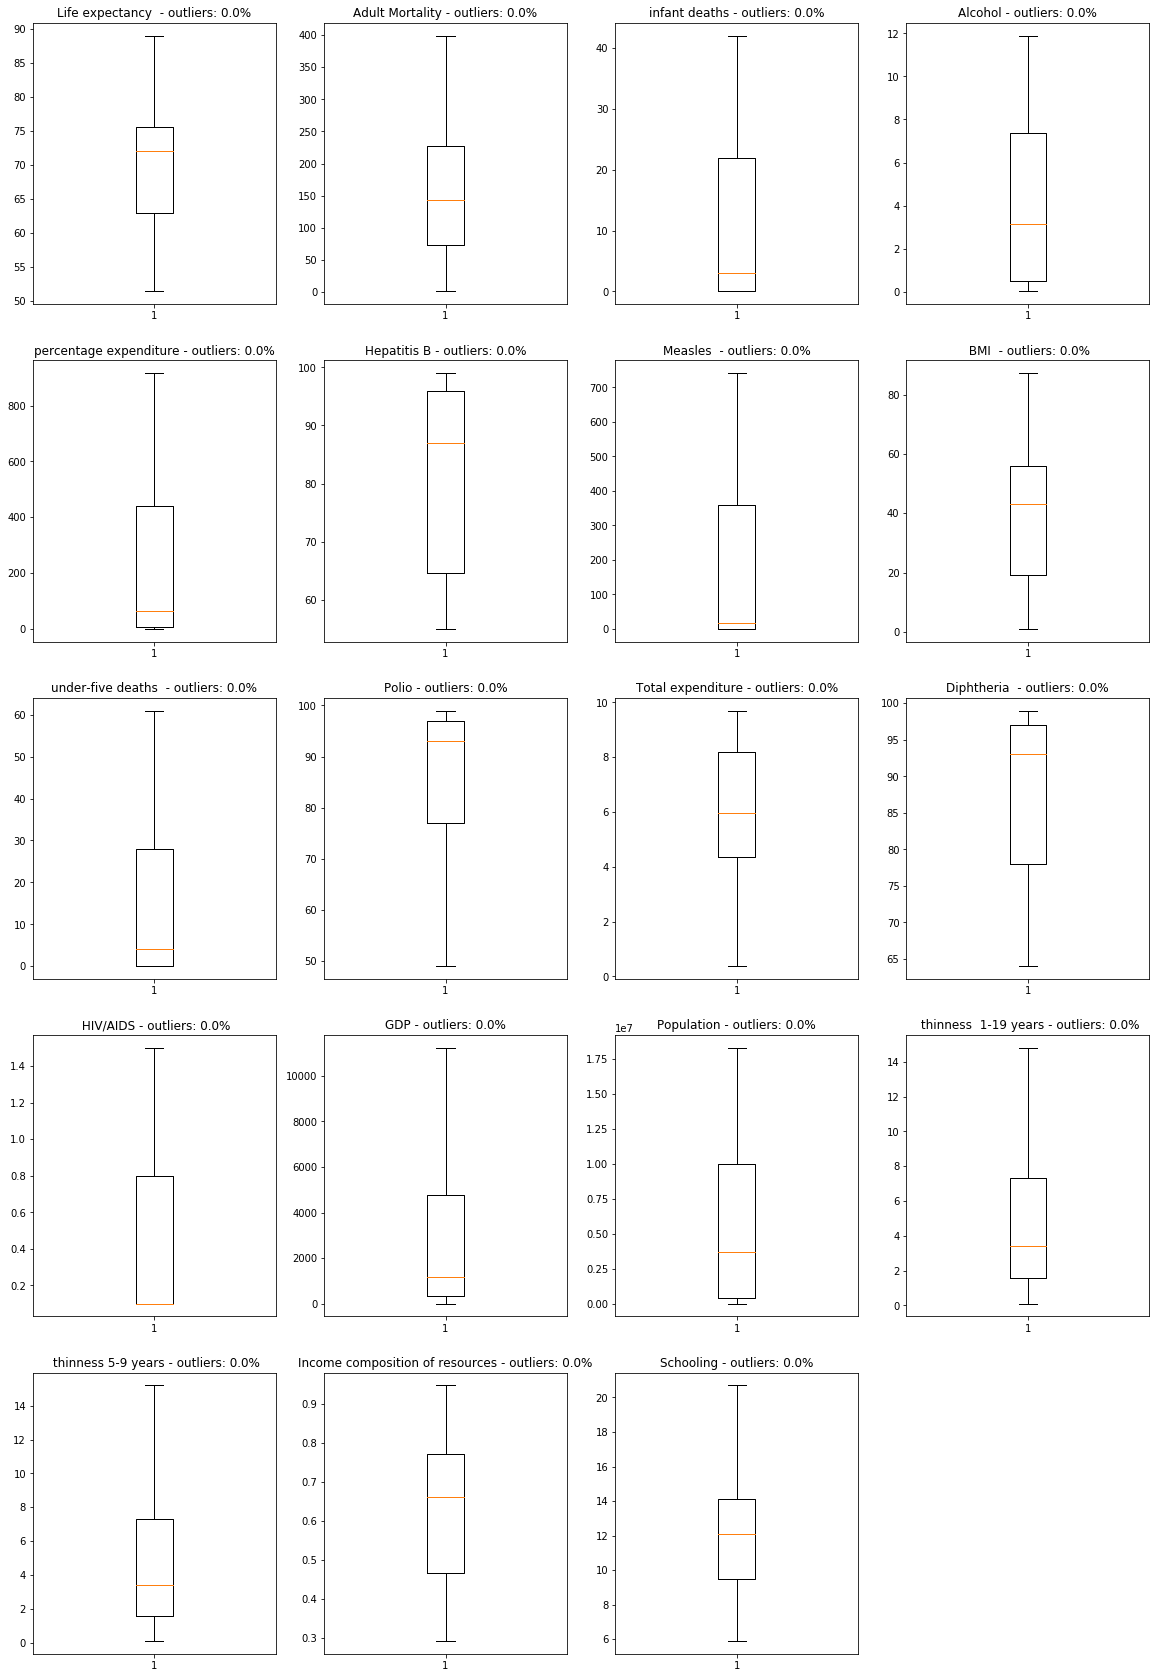

In [57]:
life_df2 = life_df1.copy()

life_df2['Life expectancy '] = winsorize(life_df2['Life expectancy '], (0.05, 0))
life_df2['Adult Mortality'] = winsorize(life_df2['Adult Mortality'], (0, 0.05))
life_df2['infant deaths'] = winsorize(life_df2['infant deaths'], (0, 0.15))
life_df2['Alcohol'] = winsorize(life_df2['Alcohol'], (0, 0.05))
life_df2['percentage expenditure'] = winsorize(life_df2['percentage expenditure'], (0, 0.15))
life_df2['Hepatitis B'] = winsorize(life_df2['Hepatitis B'], (0.1, 0))
life_df2['Measles '] = winsorize(life_df2['Measles '], (0, 0.2))
life_df2['under-five deaths '] = winsorize(life_df2['under-five deaths '], (0, 0.15))
life_df2['Polio'] = winsorize(life_df2['Polio'], (0.1, 0))
life_df2['Total expenditure'] = winsorize(life_df2['Total expenditure'], (0, 0.05))
life_df2['Diphtheria '] = winsorize(life_df2['Diphtheria '], (0.15, 0))
life_df2[' HIV/AIDS'] = winsorize(life_df2[' HIV/AIDS'], (0, 0.2))
life_df2['GDP'] = winsorize(life_df2['GDP'], (0, 0.15))
life_df2['Population'] = winsorize(life_df2['Population'], (0, 0.1))
life_df2[' thinness  1-19 years'] = winsorize(life_df2[' thinness  1-19 years'], (0, 0.05))
life_df2[' thinness 5-9 years'] = winsorize(life_df2[' thinness 5-9 years'], (0, 0.05))
life_df2['Income composition of resources'] = winsorize(life_df2['Income composition of resources'], (0.05, 0))
life_df2['Schooling'] = winsorize(life_df2['Schooling'], (0.05, 0))

plt.figure(figsize=(20,30))

for variable,i in columns.items():
                     plt.subplot(5,4,i)
                     plt.boxplot(life_df2[variable],whis=1.5)
                     plt.title('{} - outliers: {}%'.format(variable, outliers(life_df2[variable])))

plt.show()


### Bivariate analysis

looking at each variable on its own:

In [58]:
life_df2.describe(include= 'all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938,2938.000000,2938,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
unique,193,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Seychelles,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.518720,NaN,69.377242,160.072030,11.939755,4.244632,258.764731,81.206284,203.118108,38.057365,16.695371,85.024506,6.015328,86.787270,0.469197,3247.506295,6.020413e+06,4.800170,4.829135,0.628464,11.880952
std,NaN,4.613841,NaN,9.108610,110.266425,15.657188,3.958488,338.489649,15.651974,296.980200,20.076400,22.638913,16.169032,2.240285,12.461996,0.569172,3951.566425,6.090857e+06,4.024216,4.091031,0.178953,3.137261
min,NaN,2000.000000,NaN,51.400000,1.000000,0.000000,0.010000,0.000000,55.000000,0.000000,1.000000,0.000000,49.000000,0.370000,64.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.291000,5.900000
25%,NaN,2004.000000,NaN,63.000000,74.000000,0.000000,0.470000,4.685343,64.562500,0.000000,19.000000,0.000000,77.000000,4.370000,78.000000,0.100000,340.015425,4.189172e+05,1.600000,1.600000,0.465000,9.500000
50%,NaN,2008.000000,NaN,72.000000,144.000000,3.000000,3.130000,64.912906,87.000000,17.000000,43.000000,4.000000,93.000000,5.950000,93.000000,0.100000,1171.983435,3.675929e+06,3.400000,3.400000,0.662000,12.100000
75%,NaN,2012.000000,NaN,75.600000,228.000000,22.000000,7.390000,441.534144,96.000000,360.250000,56.100000,28.000000,97.000000,8.190000,97.000000,0.800000,4779.405190,9.972260e+06,7.300000,7.300000,0.772000,14.100000


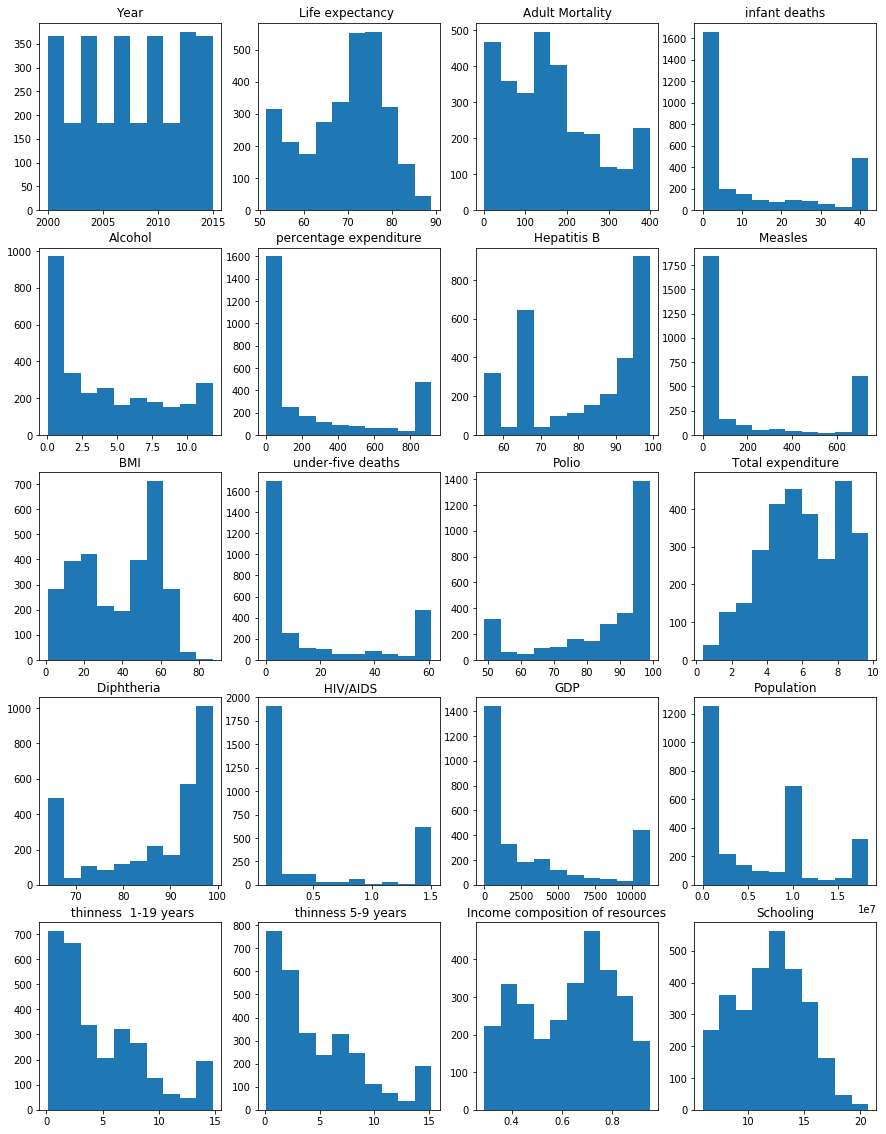

In [59]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(fill_list, 1):
    plt.subplot(5, 4, i)
    plt.hist(life_df2[col])
    plt.title(col)

About categorical data we can see that the variable of year is in a range of 2000 - 2015, and the variable of countriy contains 193 unque countries. For the varaiable of status we are plotting bellow: 

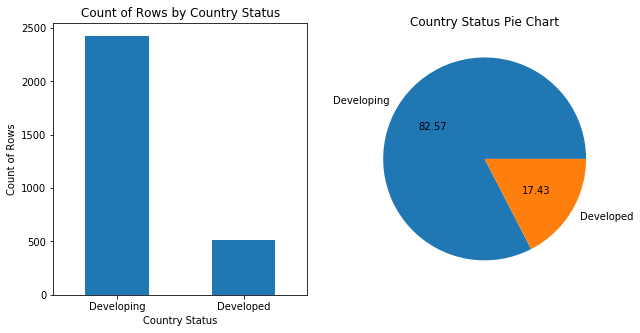

In [60]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
life_df2.Status.value_counts().plot(kind='bar')
plt.title('Count of Rows by Country Status')
plt.xlabel('Country Status')
plt.ylabel('Count of Rows')
plt.xticks(rotation=0)

plt.subplot(122)
life_df2.Status.value_counts().plot(kind='pie', autopct='%.2f')
plt.ylabel('')
plt.title('Country Status Pie Chart')

plt.show()

### Univariate analysis
Considering that the life expectancy is our target variable we are doing some analysis in relation between coninuous and categorical variables

In [61]:
# Continuous vs. Continuous

contins = list(life_df2.columns)[3:]
life_df2[contins].corr()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Life expectancy,1.000000,-0.690646,-0.585536,0.388384,0.496987,0.309522,-0.335792,0.571932,-0.609562,0.573290,0.218115,0.601168,-0.790838,0.523918,-0.013181,-0.540979,-0.536902,0.779565,0.739662
Adult Mortality,-0.690646,1.000000,0.392708,-0.207287,-0.327759,-0.198790,0.211196,-0.404189,0.410307,-0.363762,-0.121552,-0.382217,0.591560,-0.346997,0.026097,0.366772,0.373017,-0.520665,-0.475597
infant deaths,-0.585536,0.392708,1.000000,-0.330744,-0.365693,-0.278047,0.578835,-0.467696,0.995683,-0.425837,-0.142230,-0.451327,0.433051,-0.377553,0.328844,0.468115,0.480942,-0.515626,-0.551751
Alcohol,0.388384,-0.207287,-0.330744,1.000000,0.420838,0.036099,-0.177441,0.299484,-0.327465,0.259045,0.209660,0.287928,-0.192961,0.366501,-0.034070,-0.428236,-0.419132,0.409071,0.456336
percentage expenditure,0.496987,-0.327759,-0.365693,0.420838,1.000000,0.094905,-0.199501,0.338216,-0.366788,0.270291,0.115759,0.293570,-0.304622,0.852301,-0.091393,-0.339025,-0.339913,0.582710,0.569563
Hepatitis B,0.309522,-0.198790,-0.278047,0.036099,0.094905,1.000000,-0.256604,0.209994,-0.289063,0.605647,0.042440,0.667834,-0.310830,0.131483,0.024845,-0.133732,-0.137535,0.278115,0.266085
Measles,-0.335792,0.211196,0.578835,-0.177441,-0.199501,-0.256604,1.000000,-0.319901,0.576366,-0.301997,-0.164740,-0.317283,0.230424,-0.203551,0.224882,0.363688,0.368280,-0.281938,-0.338580
BMI,0.571932,-0.404189,-0.467696,0.299484,0.338216,0.209994,-0.319901,1.000000,-0.485550,0.345634,0.217284,0.359288,-0.491448,0.369522,-0.028189,-0.565825,-0.573306,0.551744,0.549472
under-five deaths,-0.609562,0.410307,0.995683,-0.327465,-0.366788,-0.289063,0.576366,-0.485550,1.000000,-0.440636,-0.144954,-0.466501,0.462488,-0.378966,0.313090,0.474137,0.486585,-0.530678,-0.562705
Polio,0.573290,-0.363762,-0.425837,0.259045,0.270291,0.605647,-0.301997,0.345634,-0.440636,1.000000,0.144114,0.859977,-0.476493,0.307634,-0.000178,-0.306828,-0.304779,0.503050,0.499545


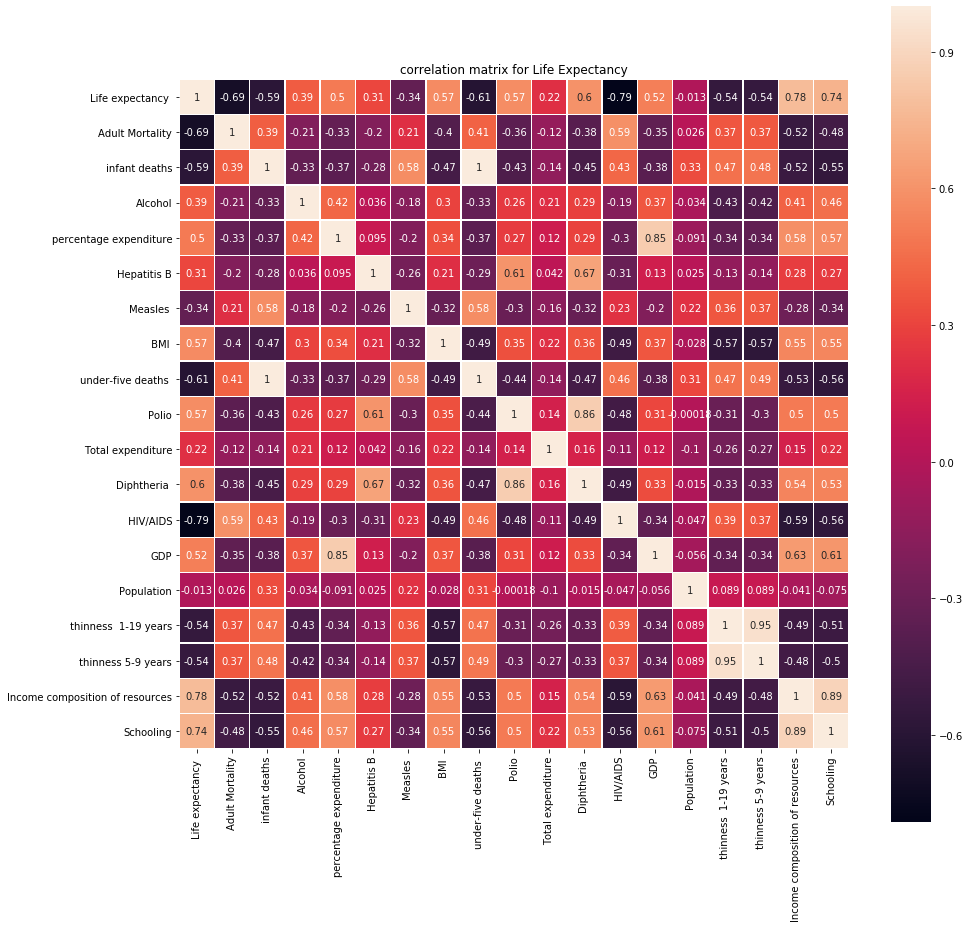

In [62]:
fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(life_df2[contins].corr(), square=True, annot=True, linewidths=.5, ax=ax)
plt.title("correlation matrix for Life Expectancy")
plt.show()

The heatmap perfectly shows the number of important correlations between variables:
Our target value, Life Expectancy, is highly correlated negatively or positively with:
Adult Mortality (negative)
HIV/AIDS (negative)
Income Composition of Resources (positive)
Schooling (positive)

And also it is lowly correlated to : population

Other variables are also somehow highly correlated, and there are some extremely correlations between some variables too. 


### Life Expectancy vs. Categoricals:

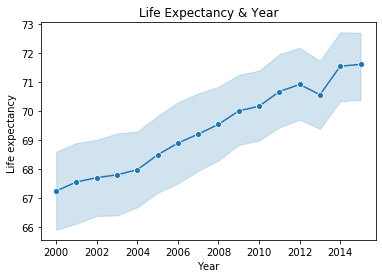

In [63]:
# Life expectancy & Year

sns.lineplot('Year', 'Life expectancy ', data=life_df2, marker='o')
plt.title('Life Expectancy & Year')
plt.show()


The graph above displays a mpstly positive trend of Life Expectancy over years.
First we should find the amount of correlation, then we do some T_tests.

In [64]:
life_df2.Year.corr(life_df2['Life expectancy '])

0.15485456172414264

In [65]:
years = list(life_df2.Year.unique())
years.sort()
life_e_year= {}
for year in years:
    ydata = life_df2[life_df2.Year == year]['Life expectancy ']
    life_e_year[year] = ydata
for year in years[:-1]:
    print(str(year) + ' to ' + str(year+1) + ':')
    print(stats.ttest_ind(life_e_year[year], life_e_year[year+1], equal_var=False))

2000 to 2001:
Ttest_indResult(statistic=-0.3205646536333975, pvalue=0.7487242772283196)
2001 to 2002:
Ttest_indResult(statistic=-0.15174008618520993, pvalue=0.8794760039196784)
2002 to 2003:
Ttest_indResult(statistic=-0.09798127448805954, pvalue=0.9220010936120946)
2003 to 2004:
Ttest_indResult(statistic=-0.1800803615179391, pvalue=0.8571896944561103)
2004 to 2005:
Ttest_indResult(statistic=-0.5256294582499911, pvalue=0.5994659839434245)
2005 to 2006:
Ttest_indResult(statistic=-0.42069766483238114, pvalue=0.6742241745479487)
2006 to 2007:
Ttest_indResult(statistic=-0.3178656444941059, pvalue=0.7507691397155348)
2007 to 2008:
Ttest_indResult(statistic=-0.35448168855838114, pvalue=0.7231834344152611)
2008 to 2009:
Ttest_indResult(statistic=-0.49952223251363714, pvalue=0.6177133724015829)
2009 to 2010:
Ttest_indResult(statistic=-0.17562795046114346, pvalue=0.860683927767239)
2010 to 2011:
Ttest_indResult(statistic=-0.5414599500254964, pvalue=0.5885218831919141)
2011 to 2012:
Ttest_indResu

Based on the amount of the correlation between Life expectancy & Year, and T_tests outputs differences between life expectancy year to year do not look significant.

In [66]:
# Life expectancy & Status

print(life_df2.groupby('Status')['Life expectancy '].mean())

developed = life_df2[life_df2.Status == 'Developed']['Life expectancy ']
developing = life_df2[life_df2.Status == 'Developing']['Life expectancy ']
stats.ttest_ind(developed, developing, equal_var=False)

Status
Developed     79.197852
Developing    67.304632
Name: Life expectancy , dtype: float64


Ttest_indResult(statistic=48.5163919051389, pvalue=9.1e-322)

The results of statistics and T_test show a significant difference between developed and developing countries.

### Running some T_tests to find relations between other continuous variables & their Status:

In [67]:
contins2 = list(life_df2.columns)[4:]

developed_df = life_df2[life_df2.Status == 'Developed']
developing_df = life_df2[life_df2.Status == 'Developing']
for col in contins2:
    print(str(col) + ' Developed/Developing t-test comparison' + ':')
    print('T-test=' +str(stats.ttest_ind(developed_df[col], developing_df[col], equal_var=False)) + '\n')

Adult Mortality Developed/Developing t-test comparison:
T-test=Ttest_indResult(statistic=-31.3112719120718, pvalue=3.6287064927050805e-173)

infant deaths Developed/Developing t-test comparison:
T-test=Ttest_indResult(statistic=-32.648182343280254, pvalue=7.57425158746043e-198)

Alcohol Developed/Developing t-test comparison:
T-test=Ttest_indResult(statistic=36.65969212364633, pvalue=5.027903027091278e-168)

percentage expenditure Developed/Developing t-test comparison:
T-test=Ttest_indResult(statistic=19.701053297639657, pvalue=1.1315806700916846e-67)

Hepatitis B Developed/Developing t-test comparison:
T-test=Ttest_indResult(statistic=0.9635793089756581, pvalue=0.3355660026591766)

Measles  Developed/Developing t-test comparison:
T-test=Ttest_indResult(statistic=-8.6261509112527, pvalue=2.5538590035347122e-17)

 BMI  Developed/Developing t-test comparison:
T-test=Ttest_indResult(statistic=19.441880572903322, pvalue=2.0806496886662902e-69)

under-five deaths  Developed/Developing t-te

### The variables of Adult Mortality, infant deaths, Alcohol, percentage expenditure, Measles, BMI, under-five deaths, Polio, Total expenditure, Diphtheria, HIV/AIDS, GDP, Population, Income composition, Schooling are highly correlated to status of a country. We should include them for the next steps of our feature engineering. 

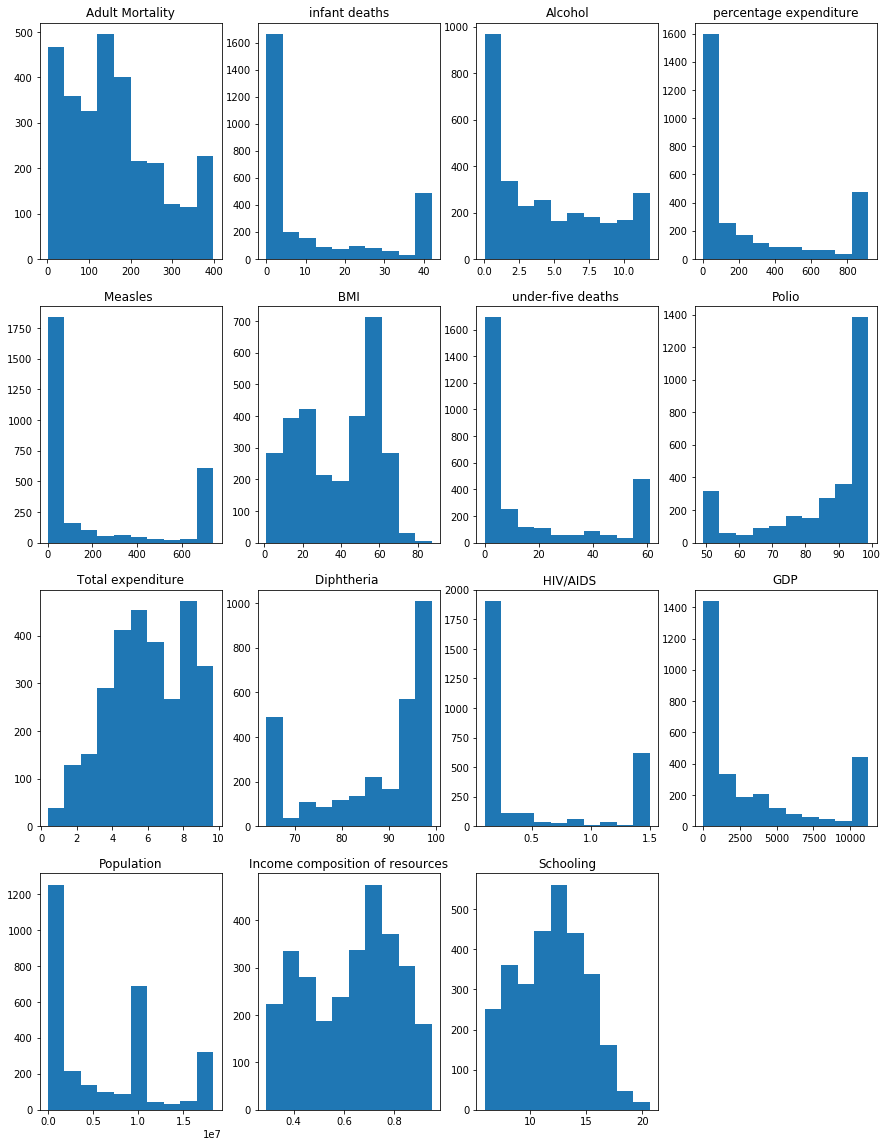

In [68]:
# Applying Box cox transformation to see if the variable disributions change to a normal disribution for Adult Mortality, 
# infant deaths, Alcohol, percentage expenditure, Measles, BMI, under-five deaths, Polio, Total expenditure, Diphtheria, 
# HIV/AIDS, GDP, Population, Income composition, Schooling


AdultM_boxcox = boxcox(life_df2['Adult Mortality'])
InfantD_boxcox = boxcox(life_df2[life_df2['infant deaths']>0]['infant deaths'])
Alcohol_boxcox = boxcox(life_df2['Alcohol'])
PercentageE_boxcox = boxcox(life_df2[life_df2['percentage expenditure']>0]['percentage expenditure'])
Measles_boxcox = boxcox(life_df2[life_df2['Measles ']>0]['Measles '])
BMI_boxcox = boxcox(life_df2[' BMI '])
Polio = boxcox(life_df2['Polio'])
TotalE_boxcox = boxcox(life_df2['Total expenditure'])
Diphtheria_boxcox = boxcox(life_df2['Diphtheria '])
HIV_boxcox = boxcox(life_df2[' HIV/AIDS'])
GDP_boxcox = boxcox(life_df2['GDP'])
Pop_boxcox = boxcox(life_df2['Population'])
IncomeC_boxcox = boxcox(life_df2['Income composition of resources'])
Schooling_boxcox = boxcox(life_df2['Schooling'])


selected_list = {'Adult Mortality':1,'infant deaths':2,'Alcohol':3,'percentage expenditure':4,
                 'Measles ':5, ' BMI ':6,'under-five deaths ':7,'Polio':8,'Total expenditure':9,'Diphtheria ':10,
                 ' HIV/AIDS':11,'GDP':12,'Population':13,'Income composition of resources':14,'Schooling':15}
plt.figure(figsize=(15, 20))
for i, col in enumerate(selected_list, 1):
    plt.subplot(4, 4, i)
    plt.hist(life_df2[col])
    plt.title(col)


The box_cox transformed data also are not normal disributions.

### Now working for transposed array

In [69]:
# Dropping Categorical data & making dummies values for Status which should be included in our features
feat_df = life_df2.join(pd.get_dummies(life_df2.Status)).drop(columns='Status').copy()
feat_df.drop(columns=['Country', 'Year'], inplace=True)
feat_df.head()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Developed,Developing
0,65.0,263.0,42,0.01,71.279624,65.0,741,19.1,61,49.0,8.16,65.0,0.1,584.259210,18294611.0,14.8,15.2,0.479,10.1,0,1
1,59.9,271.0,42,0.01,73.523582,62.0,492,18.6,61,58.0,8.18,64.0,0.1,612.696514,327582.0,14.8,15.2,0.476,10.0,0,1
2,59.9,268.0,42,0.01,73.219243,64.0,430,18.1,61,62.0,8.13,64.0,0.1,631.744976,18294611.0,14.8,15.2,0.470,9.9,0,1
3,59.5,272.0,42,0.01,78.184215,67.0,741,17.6,61,67.0,8.52,67.0,0.1,669.959000,3696958.0,14.8,15.2,0.463,9.8,0,1
4,59.2,275.0,42,0.01,7.097109,68.0,741,17.2,61,68.0,7.87,68.0,0.1,63.537231,2978599.0,14.8,15.2,0.454,9.5,0,1


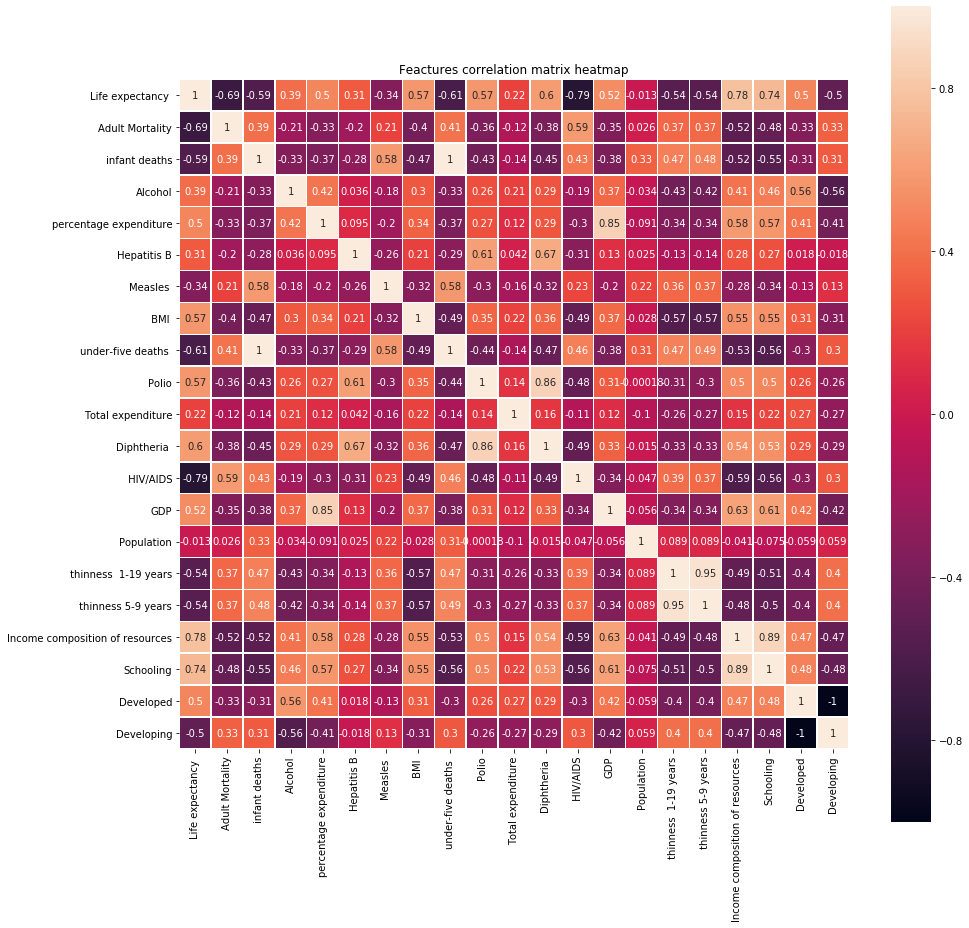

In [70]:
fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(feat_df.corr(), square=True, annot=True, linewidths=.5, ax=ax)
plt.title("Feactures correlation matrix heatmap")
plt.show()

Now we can filter some variables:

- Infant Deaths & Under Five Deaths are highly correlated we can drop Infant Deaths and keep Under Five Deaths because it is more correlated to Life Expectancy

- GDP & Percentage Expenditure are highly correlated we can drop Percentage Expenditure and keep GDP because it is more  correlated to Life Expectancy

- Polio & Diphtheria are highly correlated we can drop Polio and keep Diphtheria because it is more  correlated to Life Expectancy

- Thinness 5-9 & Thinness 10-19 are highly related, but we can drop both because of the T_test we did in previous step, and also they have a correlation less than -0.7 with Life Expectancy

- Income Composition of Resources & Schooling are highly correlated we can drop Schooling and keep Income Composition of Resources because it is more correlated with Life Expectancy

- Between Developing and Developed we can drop one because these two are the same just opposite of one another. We drop Developing 

- We also drop Population because it is not highly correlated to niether Life Expectancy nor other variables

In [71]:
#'Life expectancy ':1,'Adult Mortality':2,'infant deaths':3,'Alcohol':4,'percentage expenditure':5,'Hepatitis B':6,
#           'Measles ':7, ' BMI ':8,'under-five deaths ':9,'Polio':10,'Total expenditure':11,'Diphtheria ':12,' HIV/AIDS':13,'GDP':14,
#           'Population':15, ' thinness  1-19 years':16,' thinness 5-9 years':17,'Income composition of resources':18,'Schooling':19


feat_df.drop(columns=['infant deaths', 'percentage expenditure', 'Polio',' thinness  1-19 years', ' thinness 5-9 years',
                      'Schooling','Developing', 'Population'], inplace=True)

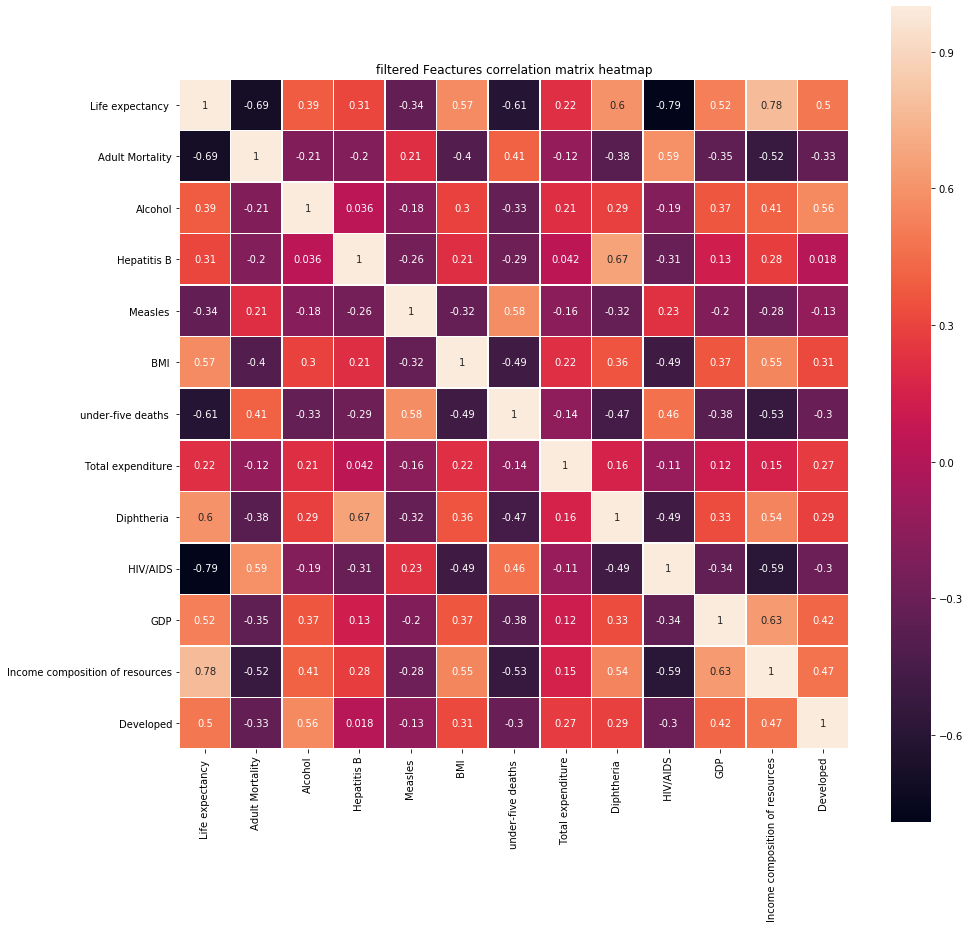

In [72]:
fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(feat_df.corr(), square=True, annot=True, linewidths=.5, ax=ax)
plt.title("filtered Feactures correlation matrix heatmap")
plt.show()

### PCA: 
Althogh we know that our data values are not normally distributed, we are lokking for if Principle Component Analyis may reduce features.

In [73]:
# Droping categorical value & the target value
pca_df = feat_df.copy()
pca_df.drop(columns= ['Developed', 'Life expectancy '], inplace=True)
len(pca_df.columns)

11

In [74]:
X = scale(pca_df)
sklearn_pca = PCA()
Y = sklearn_pca.fit_transform(X)
print('Explained variance by Principal Components:', sklearn_pca.explained_variance_ratio_)
print('Eigenvalues:', sklearn_pca.explained_variance_)

Explained variance by Principal Components: [0.40598438 0.11439519 0.09754798 0.08206123 0.07874114 0.05529421
 0.05127058 0.03559754 0.03126423 0.02595574 0.02188778]
Eigenvalues: [4.46734874 1.2587755  1.07339315 0.9029809  0.8664474  0.6084434
 0.56416839 0.39170626 0.34402366 0.28561039 0.24084752]


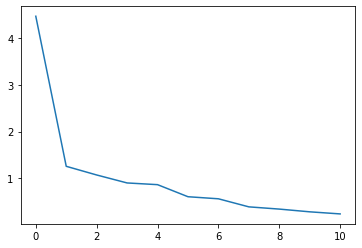

PC1 Explained Variance: 40.6%


In [75]:
plt.plot(sklearn_pca.explained_variance_)
plt.show()
print('PC1 Explained Variance:', str(round(sklearn_pca.explained_variance_ratio_[0]*100, 2))+'%')

PCA does not change that much the amount of variables. Due to having at least 90% of variances, we have to keep 8 compnents, and we can just drop three of them. PCA Variance of 40.6% does not cover that much of the total variance of all variable.

So, we should go to modelong step with 11 filtered variables. 